In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,  classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn import preprocessing
import ipaddress

import warnings
warnings.simplefilter('ignore')

## Data preprocessing

In [2]:
#DATADIR = '/home/infres/abiapo/prim/data'
DATADIR = '/home/infres/sagbo-21/Documents/PRIM/PRIM/data'

In [3]:
data = pd.read_csv(DATADIR+'/unbalance_mix_data_20_80.csv')
data.head()

,Unnamed:_0,Flow_ID,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packets,...,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,SimillarHTTP,Inbound,Label,label
0,32640,172.217.10.2-192.168.50.8-443-60967-6,172.217.10.2,443,192.168.50.8,60967,6,2018-12-01 15:49:09.036775,164,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,BENIGN,0
1,45412,172.16.0.5-192.168.50.1-51574-60224-17,172.16.0.5,51574,192.168.50.1,60224,17,2018-12-01 13:43:55.407405,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1
2,318552,192.168.50.8-4.2.2.4-61210-53-17,192.168.50.8,61210,4.2.2.4,53,17,2018-12-01 13:05:54.715600,20701,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN,0
3,1597,192.168.50.6-204.154.111.116-58086-443-6,192.168.50.6,58086,204.154.111.116,443,6,2018-12-01 13:26:18.971610,226,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN,0
4,715,192.168.50.7-52.114.77.33-50698-443-6,192.168.50.7,50698,52.114.77.33,443,6,2018-12-01 09:22:24.709768,106895,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN,0


In [4]:
data = data.drop(['Unnamed:_0'],axis=1)
data['Source_IP'] = data['Source_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data['Destination_IP'] = data['Destination_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data = data.drop(['Flow_ID'],axis=1)
data = data.drop(['Timestamp'],axis=1)
data = data.drop(['SimillarHTTP'],axis=1)

In [5]:
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [6]:
X = data.iloc[:,:-2]
y = data.iloc[:,-1].to_numpy()

In [7]:
principal_feature = ['Inbound', 'Destination_IP', 'URG_Flag_Count', 'Down_Up_Ratio', 'Protocol', 
                     'Min_Packet_Length', 'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean', 
                     'Avg_Fwd_Segment_Size', 'Packet_Length_Mean', 'Average_Packet_Size', 'Destination_Port', 
                     'CWE_Flag_Count', 'Fwd_Packets_s', 'Flow_Packets_s', 'Fwd_Packet_Length_Max', 
                     'Bwd_Packet_Length_Mean', 'Flow_Bytes_s', 'Init_Win_bytes_forward', 'Packet_Length_Std']

In [8]:
X = X[principal_feature]

## Models

In [9]:
def cal_accuracy(y_test, y_pred): 
    print("Confusion Matrix: ")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 
    print("Report : ", classification_report(y_test, y_pred))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)   

In [11]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

#### Decision Tree

Confusion Matrix: 
Accuracy :  99.99500131215557
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32482
           1       1.00      1.00      1.00    127560

    accuracy                           1.00    160042
   macro avg       1.00      1.00      1.00    160042
weighted avg       1.00      1.00      1.00    160042



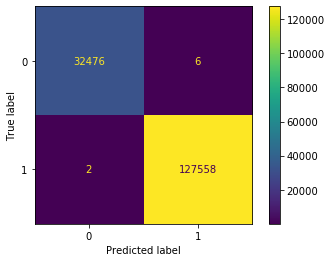

In [12]:
from sklearn.tree import DecisionTreeClassifier 
clf_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
clf_entropy.fit(X_train, y_train) 
y_pred_entropy = clf_entropy.predict(X_test)
cal_accuracy(y_test, y_pred_entropy)

#### Naive Bayes

Confusion Matrix: 
Accuracy :  97.61999975006562
Report :                precision    recall  f1-score   support

           0       0.90      1.00      0.94     32482
           1       1.00      0.97      0.98    127560

    accuracy                           0.98    160042
   macro avg       0.95      0.98      0.96    160042
weighted avg       0.98      0.98      0.98    160042



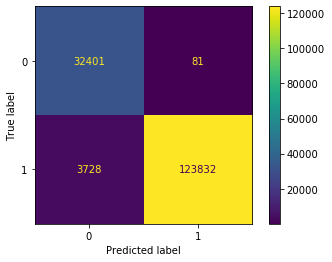

In [13]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
y_pred_nb = gnb.predict(X_test)
cal_accuracy(y_test, y_pred_nb)

In [14]:
pred_prob_dt = clf_entropy.predict_proba(X_test)
pred_prob_nb = gnb.predict_proba(X_test)

# roc curve for models
fpr_dt, tpr_dt, thresh_dt = roc_curve(y_test, pred_prob_dt[:,1], pos_label=1)
fpr_nb, tpr_nb, thresh_nb = roc_curve(y_test, pred_prob_nb[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_dt = roc_auc_score(y_test, pred_prob_dt[:,1])
auc_score_nb = roc_auc_score(y_test, pred_prob_nb[:,1])

print(auc_score_dt, auc_score_nb)

0.9998998017069984 0.9990281292681693


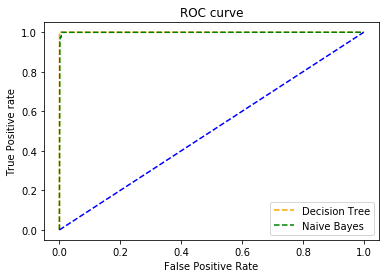

In [15]:
# plot roc curves
plt.plot(fpr_dt, tpr_dt, linestyle='--',color='orange', label='Decision Tree')
plt.plot(fpr_nb, tpr_nb, linestyle='--',color='green', label='Naive Bayes')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

#### Logistic Regression

Confusion Matrix: 
Accuracy :  99.85066420064733
Report :                precision    recall  f1-score   support

           0       1.00      0.99      1.00     32482
           1       1.00      1.00      1.00    127560

    accuracy                           1.00    160042
   macro avg       1.00      1.00      1.00    160042
weighted avg       1.00      1.00      1.00    160042



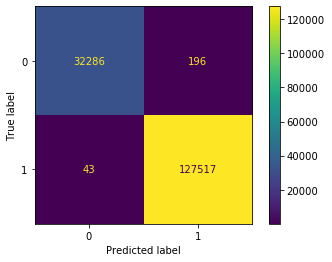

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', random_state = 0)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
cal_accuracy(y_test, y_pred_lr)

#### Support Vector Machine with gaussian kernel

Confusion Matrix: 
Accuracy :  99.98500393646668
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32482
           1       1.00      1.00      1.00    127560

    accuracy                           1.00    160042
   macro avg       1.00      1.00      1.00    160042
weighted avg       1.00      1.00      1.00    160042



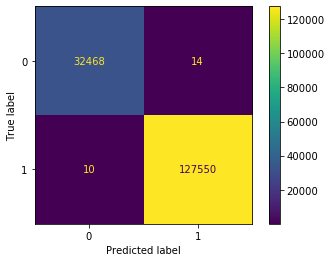

In [17]:
from sklearn.svm import SVC
clf_svm = SVC(kernel = 'rbf', random_state = 0,C=10.0, gamma=0.1,probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svc = clf_svm.predict(X_test)
cal_accuracy(y_test, y_pred_svc)

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob_logreg = logreg.predict_proba(X_test)
pred_prob_svm = clf_svm.predict_proba(X_test)

# roc curve for models
fpr_logreg, tpr_logreg, thresh_logreg = roc_curve(y_test, pred_prob_logreg[:,1], pos_label=1)
fpr_svm, tpr_svm, thresh_svm = roc_curve(y_test, pred_prob_svm[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_logreg = roc_auc_score(y_test, pred_prob_logreg[:,1])
auc_score_svm = roc_auc_score(y_test, pred_prob_svm[:,1])

print(auc_score_logreg, auc_score_svm)

0.9997097963357624 0.9999594378189419


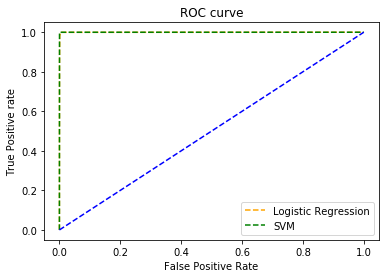

In [19]:
# plot roc curves
plt.plot(fpr_logreg, tpr_logreg, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, linestyle='--',color='green', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

#### K Nearest Neighbor

Confusion Matrix: 
Accuracy :  99.983129428525
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32482
           1       1.00      1.00      1.00    127560

    accuracy                           1.00    160042
   macro avg       1.00      1.00      1.00    160042
weighted avg       1.00      1.00      1.00    160042



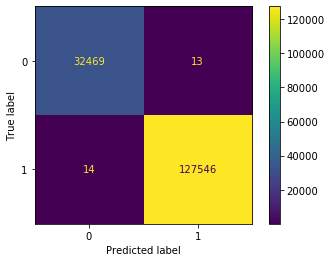

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
cal_accuracy(y_test, y_pred_knn)

#### Random Forest

Confusion Matrix: 
Accuracy :  99.994376476175
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32482
           1       1.00      1.00      1.00    127560

    accuracy                           1.00    160042
   macro avg       1.00      1.00      1.00    160042
weighted avg       1.00      1.00      1.00    160042



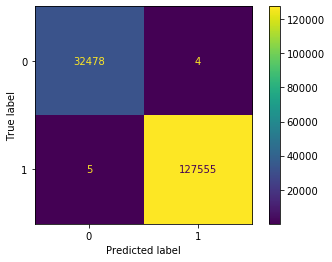

In [21]:
from sklearn.ensemble import RandomForestClassifier
rndForest =RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
rndForest.fit(X_train,y_train)
y_pred_rf = rndForest.predict(X_test)
cal_accuracy(y_test, y_pred_rf)

In [22]:
pred_prob_knn = knn.predict_proba(X_test)
pred_prob_rf = rndForest.predict_proba(X_test)

# roc curve for models
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, pred_prob_knn[:,1], pos_label=1)
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_knn = roc_auc_score(y_test, pred_prob_knn[:,1])
auc_score_rf = roc_auc_score(y_test, pred_prob_rf[:,1])

print(auc_score_knn, auc_score_rf)

0.9998762169921392 0.9999690477919903


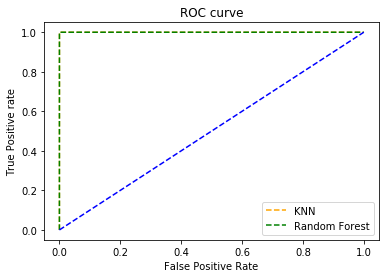

In [23]:
# plot roc curves
plt.plot(fpr_knn, tpr_knn, linestyle='--',color='orange', label='KNN')
plt.plot(fpr_rf, tpr_rf, linestyle='--',color='green', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

 #### LightGBM

Confusion Matrix: 
Accuracy :  99.99687582009722
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32482
           1       1.00      1.00      1.00    127560

    accuracy                           1.00    160042
   macro avg       1.00      1.00      1.00    160042
weighted avg       1.00      1.00      1.00    160042



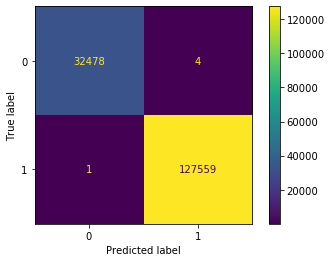

In [24]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)
cal_accuracy(y_test, y_pred_lgb)

In [25]:
print('Training set score: {:.4f}'.format(lgb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lgb.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 1.0000


#### XGBoost

Confusion Matrix: 
Accuracy :  99.99500131215557
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32482
           1       1.00      1.00      1.00    127560

    accuracy                           1.00    160042
   macro avg       1.00      1.00      1.00    160042
weighted avg       1.00      1.00      1.00    160042



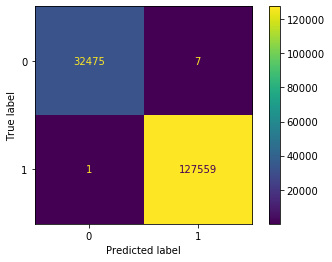

In [26]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
cal_accuracy(y_test, y_pred_xgb)

In [27]:
print('Training set score: {:.4f}'.format(xgb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(xgb.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 1.0000


In [28]:
pred_prob_xgb = xgb.predict_proba(X_test)
pred_prob_lgb = lgb.predict_proba(X_test)

# roc curve for models
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)
fpr_lgb, tpr_lgb, thresh_lgb = roc_curve(y_test, pred_prob_lgb[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_xgb = roc_auc_score(y_test, pred_prob_xgb[:,1])
auc_score_lgb = roc_auc_score(y_test, pred_prob_lgb[:,1])

print(auc_score_xgb, auc_score_lgb)

0.9999966360991424 0.9999998276779157


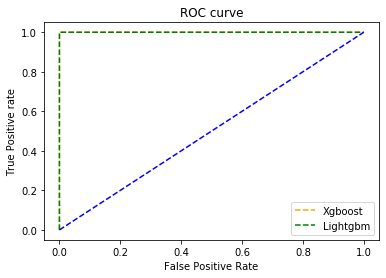

In [29]:
# plot roc curves
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='orange', label='Xgboost')
plt.plot(fpr_lgb, tpr_lgb, linestyle='--',color='green', label='Lightgbm')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Multi Layer Perceptron

Confusion Matrix: 
Accuracy :  99.98875295235001
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32482
           1       1.00      1.00      1.00    127560

    accuracy                           1.00    160042
   macro avg       1.00      1.00      1.00    160042
weighted avg       1.00      1.00      1.00    160042



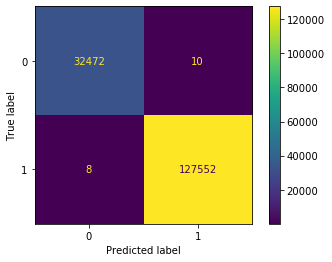

In [30]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(150,100),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam')
mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_test)
cal_accuracy(y_test, y_pred_mlp)

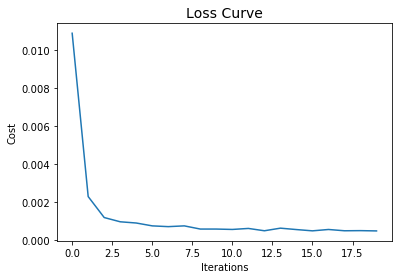

In [31]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [32]:
print('Training set score: {:.4f}'.format(mlp_clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(mlp_clf.score(X_test, y_test)))

Training set score: 0.9999
Test set score: 0.9999


In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob_mlp = mlp_clf.predict_proba(X_test)

# roc curve for models
fpr_mlp, tpr_mlp, thresh_mlp = roc_curve(y_test, pred_prob_mlp[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_mlp = roc_auc_score(y_test, pred_prob_mlp[:,1])

print(auc_score_mlp)

0.99997730561591


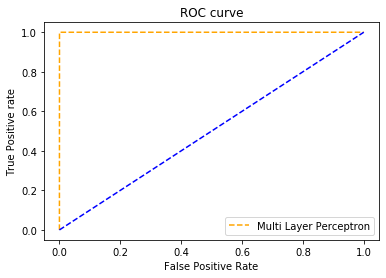

In [34]:
# plot roc curves
plt.plot(fpr_mlp, tpr_mlp, linestyle='--',color='orange', label='Multi Layer Perceptron')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

## Recap

In [ ]:
result_recap = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','F1-score','AUC'])
result_recap = result_recap.append([{'Model':'Decision Tree', 'Accuracy':accuracy_score(y_test,y_pred_entropy)*100, 'Precision' : precision_score(y_test,y_pred_entropy)*100 ,
                     'Recall': recall_score(y_test,y_pred_entropy)*100 , 'F1-score': f1_score(y_test, y_pred_entropy)*100 , 'AUC' :auc_score_dt*100 },
                     {'Model':'Naive Bayes', 'Accuracy':accuracy_score(y_test,y_pred_nb)*100, 'Precision' : precision_score(y_test,y_pred_nb)*100 ,
                     'Recall': recall_score(y_test,y_pred_nb)*100 , 'F1-score': f1_score(y_test, y_pred_nb)*100 , 'AUC' :auc_score_nb*100 },
                     {'Model':'Logistic Regression', 'Accuracy':accuracy_score(y_test,y_pred_lr)*100, 'Precision' : precision_score(y_test,y_pred_lr)*100 ,
                     'Recall': recall_score(y_test,y_pred_lr)*100 , 'F1-score': f1_score(y_test, y_pred_lr)*100 , 'AUC' :auc_score_logreg*100 },
                    {'Model':'SVM', 'Accuracy':accuracy_score(y_test,y_pred_svc)*100, 'Precision' : precision_score(y_test,y_pred_svc)*100 ,
                     'Recall': recall_score(y_test,y_pred_svc)*100 , 'F1-score': f1_score(y_test, y_pred_svc)*100 , 'AUC' :auc_score_svm*100 },
                    {'Model':'KNN', 'Accuracy':accuracy_score(y_test,y_pred_knn)*100, 'Precision' : precision_score(y_test,y_pred_knn)*100 ,
                     'Recall': recall_score(y_test,y_pred_knn)*100 , 'F1-score': f1_score(y_test, y_pred_knn)*100 , 'AUC' :auc_score_knn*100 },
                    {'Model':'Random Forest', 'Accuracy':accuracy_score(y_test,y_pred_rf)*100, 'Precision' : precision_score(y_test,y_pred_rf)*100 ,
                     'Recall': recall_score(y_test,y_pred_rf)*100 , 'F1-score': f1_score(y_test, y_pred_rf)*100 , 'AUC' :auc_score_rf*100 },
                    {'Model':'Xgboost', 'Accuracy':accuracy_score(y_test,y_pred_xgb)*100, 'Precision' : precision_score(y_test,y_pred_xgb)*100 ,
                     'Recall': recall_score(y_test,y_pred_xgb)*100 , 'F1-score': f1_score(y_test, y_pred_xgb)*100 , 'AUC' :auc_score_xgb*100 },
                    {'Model':'Ligtgbm', 'Accuracy':accuracy_score(y_test,y_pred_lgb)*100, 'Precision' : precision_score(y_test,y_pred_lgb)*100 ,
                     'Recall': recall_score(y_test,y_pred_lgb)*100 , 'F1-score': f1_score(y_test, y_pred_lgb)*100 , 'AUC' :auc_score_lgb*100},
                    {'Model':'Multi Layer Perceptron', 'Accuracy':accuracy_score(y_test,y_pred_mlp)*100, 'Precision' : precision_score(y_test,y_pred_mlp)*100 ,
                     'Recall': recall_score(y_test,y_pred_mlp)*100 , 'F1-score': f1_score(y_test, y_pred_mlp)*100 , 'AUC' :auc_score_mlp*100}],ignore_index=True)
result_recap.set_index('Model',inplace = True)
result_recap

In [ ]:
plt.style.use('seaborn')
result_recap.plot(kind='bar',figsize=(24,12))
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(fpr_dt, tpr_dt, linestyle='--', label='Decision Tree')
plt.plot(fpr_nb, tpr_nb, linestyle='--', label='Naive Bayes')

plt.plot(fpr_logreg, tpr_logreg, linestyle='--', label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, linestyle='--', label='SVM')

plt.plot(fpr_knn, tpr_knn, linestyle='--', label='KNN')
plt.plot(fpr_rf, tpr_rf, linestyle='--', label='Random Forest')

plt.plot(fpr_xgb, tpr_xgb, linestyle='--', label='Xgboost')
plt.plot(fpr_lgb, tpr_lgb, linestyle='--', label='Lightgbm')

plt.plot(fpr_mlp, tpr_mlp, linestyle='--', label='Multi Layer Perceptron')
plt.plot(p_fpr, p_tpr, linestyle='--')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();